# libraries Set up 

In [3]:
# Standard PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# snnTorch imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

# Plotting and animation
import matplotlib.pyplot as plt
import numpy as np
import itertools # for iterating through the dataloader

# Data Loading and Preprocessing

In [9]:
# Dataloader arguments
batch_size = 128
data_path = '/home/sebas_dev_linux/projects/snn_project/data/'

# Define a transform to flatten the data and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)) # Normalize to [0, 1]
])

# Load the MNIST datasets
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

--- RAW IMAGE (Before Transform) ---
Data Type: <class 'PIL.Image.Image'>
Image Size: (28, 28)
Label: 5

--- TRANSFORMED TENSOR (After Transform) ---
Data Type: <class 'torch.Tensor'>
Tensor Shape: torch.Size([1, 28, 28])
Pixel Value Range: Min=0.0, Max=1.0
Label: 5



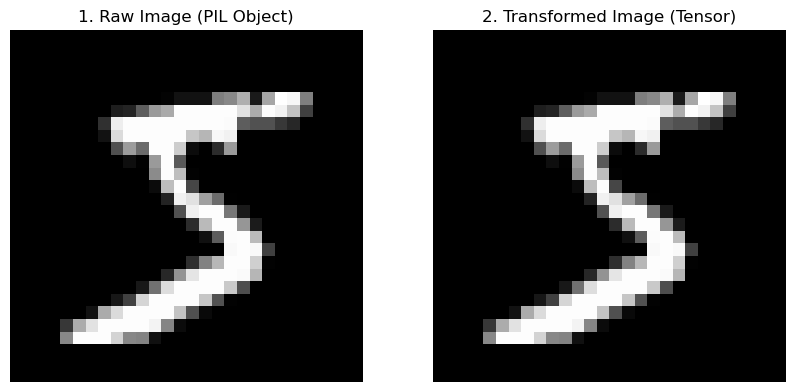

In [10]:
mnist_train_raw = datasets.MNIST(data_path, train=True, download=True, transform=None)

# --- Let's get the first image from both datasets ---
raw_image, raw_label = mnist_train_raw[0]
transformed_tensor, transformed_label = mnist_train[0]


# --- Now, let's inspect and plot them ---

print("--- RAW IMAGE (Before Transform) ---")
print(f"Data Type: {type(raw_image)}")
print(f"Image Size: {raw_image.size}")
print(f"Label: {raw_label}\n")


print("--- TRANSFORMED TENSOR (After Transform) ---")
print(f"Data Type: {type(transformed_tensor)}")
print(f"Tensor Shape: {transformed_tensor.shape}")
print(f"Pixel Value Range: Min={torch.min(transformed_tensor)}, Max={torch.max(transformed_tensor)}")
print(f"Label: {transformed_label}\n")


# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the raw image
axes[0].imshow(raw_image, cmap='gray')
axes[0].set_title("1. Raw Image (PIL Object)")
axes[0].set_axis_off()

# Plotting the transformed tensor
# .squeeze() removes the channel dimension [1, 28, 28] -> [28, 28] for plotting
axes[1].imshow(transformed_tensor.squeeze(), cmap='gray')
axes[1].set_title("2. Transformed Image (Tensor)")
axes[1].set_axis_off()

plt.show()

# Understanding SNN Concepts

Goal: From Pixels to Spikes

1. The Leaky Integrate-and-Fire (LIF) Neuron:
This is the most common type of spiking neuron. Think of it like a bucket with a small hole:
Integrate: Incoming spikes (current) fill the bucket (membrane potential).
Leak: The bucket slowly leaks over time (membrane potential decays).
Fire: If the water level reaches a certain threshold, the bucket empties completely (fires a spike) and then resets.
2. Temporal Data Encoding:
How do we turn a static MNIST image into something an SNN can process over time? We need to generate spike trains. A simple and effective method is rate encoding, where the pixel intensity determines the firing frequency.
A pixel value of 0 (black) will generate no spikes.
A pixel value of 1 (white) will generate spikes at a high frequency.
Values in between will generate spikes at an intermediate frequency.
Let's visualize this encoding for one image.

Original image shape: torch.Size([1, 28, 28])
Spike data shape: torch.Size([25, 1, 784])


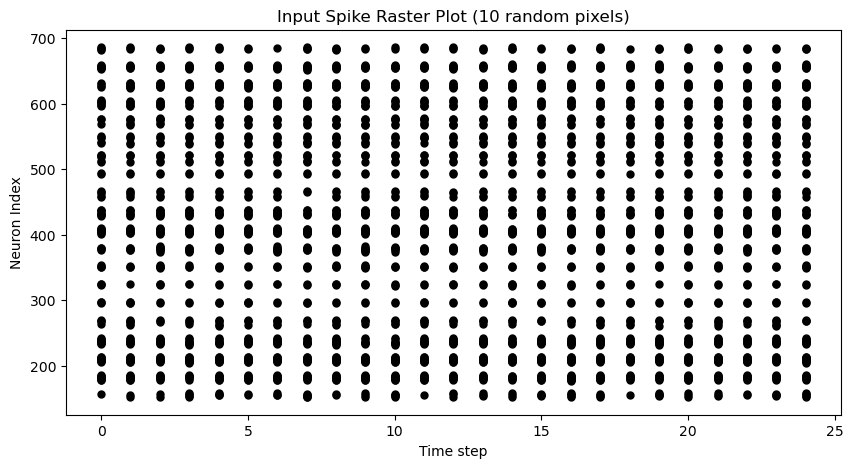

In [ ]:
# Set the number of time steps for our simulation
num_steps = 25

# Grab a single sample
data_iterator = iter(train_loader)
images, labels = next(data_iterator)
sample_image = images[0] # Take the first image in the batch

# Generate spikes using rate encoding
# The image is 1x28x28, we flatten it to 784 inputs
# spikegen.rate returns a tensor of shape [time, batch, features]
spike_data = spikegen.rate(sample_image.view(1, -1), num_steps=num_steps)

# sample_image.view(1, -1):
# sample_image initially has a shape of [1, 28, 28] (1 color channel, 28 pixels high, 28 pixels wide).
# A standard fully-connected layer (nn.Linear) doesn't understand 2D grids; it expects a flat vector of features.
# The .view(1, -1) command is a powerful reshaping tool in PyTorch. It means "reshape this tensor to have a size of 1 in the first dimension, and figure out the rest automatically (-1)".
# This flattens the 28x28 grid into a single vector of 784 pixels. So the shape becomes [1, 784]. This represents a "batch" of 1 image, with 784 input features (one for each pixel).

# |1 1 1| --> |1 1 1 1 1 1 1 1 1|
# |1 1 1|
# |1 1 1|


print("Original image shape:", sample_image.shape)
print("Spike data shape:", spike_data.shape) # Shape: [time_steps, batch_size, flattened_pixels]

# We ended with a [25, 1, 784] tensor. Let's read this new shape:
# Dimension 0 (Size 25): The Time dimension. This is the new, crucial dimension. It holds one "frame" of our spike movie at each index.
# Dimension 1 (Size 1): The Batch dimension. We are still processing one image.
# Dimension 2 (Size 784): The Feature dimension. These are our 784 input neurons, corresponding to the flattened pixels.


# Let's visualize the spikes from a few input neurons (pixels)
# We will plot the spikes for 10 pixels
fig, ax = plt.subplots(figsize=(10, 5))
splt.raster(spike_data[:, 0, :].squeeze(), ax, s=25, c="black") # Plotting for the first (and only) sample in our mini-batch
ax.set_title("Input Spike Raster Plot (10 random pixels)")
ax.set_xlabel("Time step")
ax.set_ylabel("Neuron Index")
plt.show()

## Visualization how the spike undestand the data

--- Step 1: Grab a Single Image ---
The selected image is a digit: 9
Original image tensor shape: torch.Size([1, 28, 28])
This shape means [Color Channels, Height, Width]

--- Step 2: Reshape the Image for Spike Generation ---
Shape after flattening: torch.Size([1, 784])
This is now [1 image, 784 pixels]

--- Step 3: Generate the Spike Train with Rate Encoding ---
Final spike data shape: torch.Size([25, 1, 784])
This final shape means [Time Steps, Batch Size, Features/Neurons]
Total spikes generated for this image over 25 steps: 2367.0
Average spikes per step: 94.68

--- Step 4: Visualize the Image and its Spike Representation ---


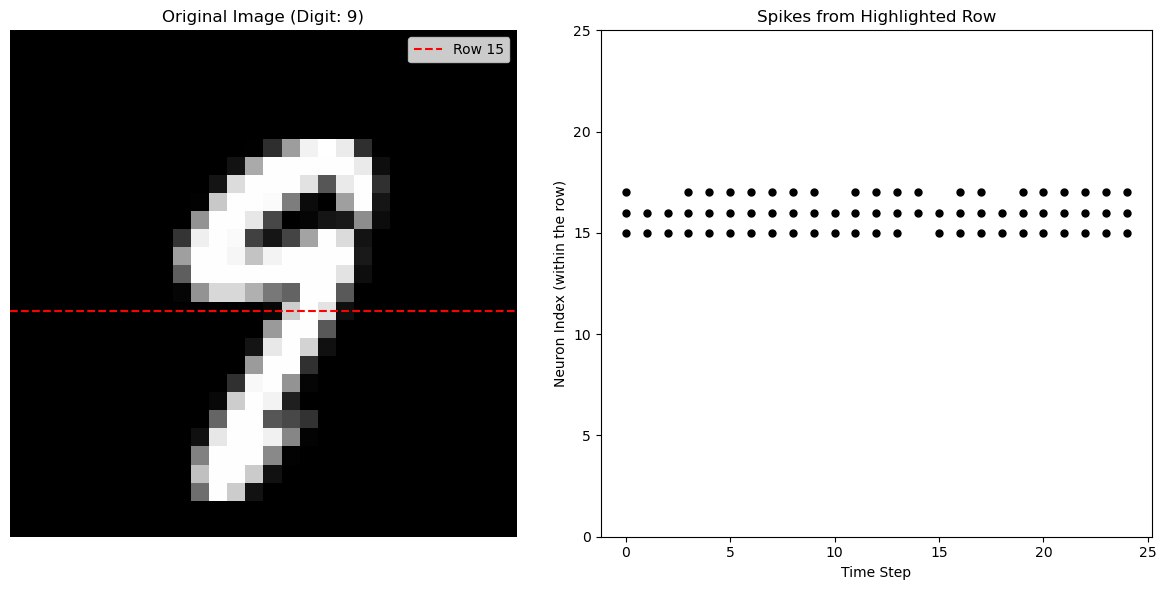

In [58]:
import torch
import snntorch as snn
from snntorch import spikegen, spikeplot as splt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# --- Recreate the necessary components from our project ---
# Dataloader arguments
batch_size = 128
data_path = '/home/sebas_dev_linux/projects/snn_project/data/'
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# --- Start of the detailed breakdown ---

print("--- Step 1: Grab a Single Image ---")
# Get a batch of data
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Select the first image and its label from the batch
sample_image = images[0]
sample_label = labels[0]

print(f"The selected image is a digit: {sample_label.item()}")
print(f"Original image tensor shape: {sample_image.shape}")
print("This shape means [Color Channels, Height, Width]\n")


print("--- Step 2: Reshape the Image for Spike Generation ---")
# The spikegen function expects a 2D tensor of [batch_size, features]
# We are processing one image, so batch_size=1
# The features are the 28x28 pixels flattened into a single row
flattened_image = sample_image.view(1, -1)
print(f"Shape after flattening: {flattened_image.shape}")
print("This is now [1 image, 784 pixels]\n")


print("--- Step 3: Generate the Spike Train with Rate Encoding ---")
num_steps = 25
# Generate spikes
spike_data = spikegen.rate(flattened_image, num_steps=num_steps)

print(f"Final spike data shape: {spike_data.shape}")
print("This final shape means [Time Steps, Batch Size, Features/Neurons]")
total_spikes = torch.sum(spike_data)
print(f"Total spikes generated for this image over {num_steps} steps: {total_spikes.item()}")
print(f"Average spikes per step: {total_spikes.item() / num_steps:.2f}\n")


print("--- Step 4: Visualize the Image and its Spike Representation ---")
# Create a figure with two subplots, side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: The Original Image ---
# .squeeze() removes the channel dimension for plotting
axes[0].imshow(sample_image.squeeze(), cmap='gray')
axes[0].set_title(f"Original Image (Digit: {sample_label.item()})")
axes[0].set_axis_off()

# Highlight a specific row to analyze
row_to_analyze = 15  #⭐
axes[0].axhline(y=row_to_analyze, color='red', linestyle='--', label=f'Row {row_to_analyze}')
axes[0].legend()


# --- Plot 2: The Raster Plot of Spikes from the Highlighted Row ---
# Calculate the neuron indices that correspond to the highlighted row
start_neuron_index = row_to_analyze * 28
end_neuron_index = start_neuron_index + 28

# Get the spike data for just those 28 neurons
row_spike_data = spike_data[:, 0, start_neuron_index:end_neuron_index]

splt.raster(row_spike_data, axes[1], s=25, c='black')
axes[1].set_title(f"Spikes from Highlighted Row")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Neuron Index (within the row)")
axes[1].set_yticks(np.arange(0, 28, 5)) # Make y-axis cleaner

plt.tight_layout()
plt.show()

In [29]:
spike_data[4]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0.,

Found an image of a '2'.
Found 943 early spikes, 1061 middle spikes, and 945 late spikes.


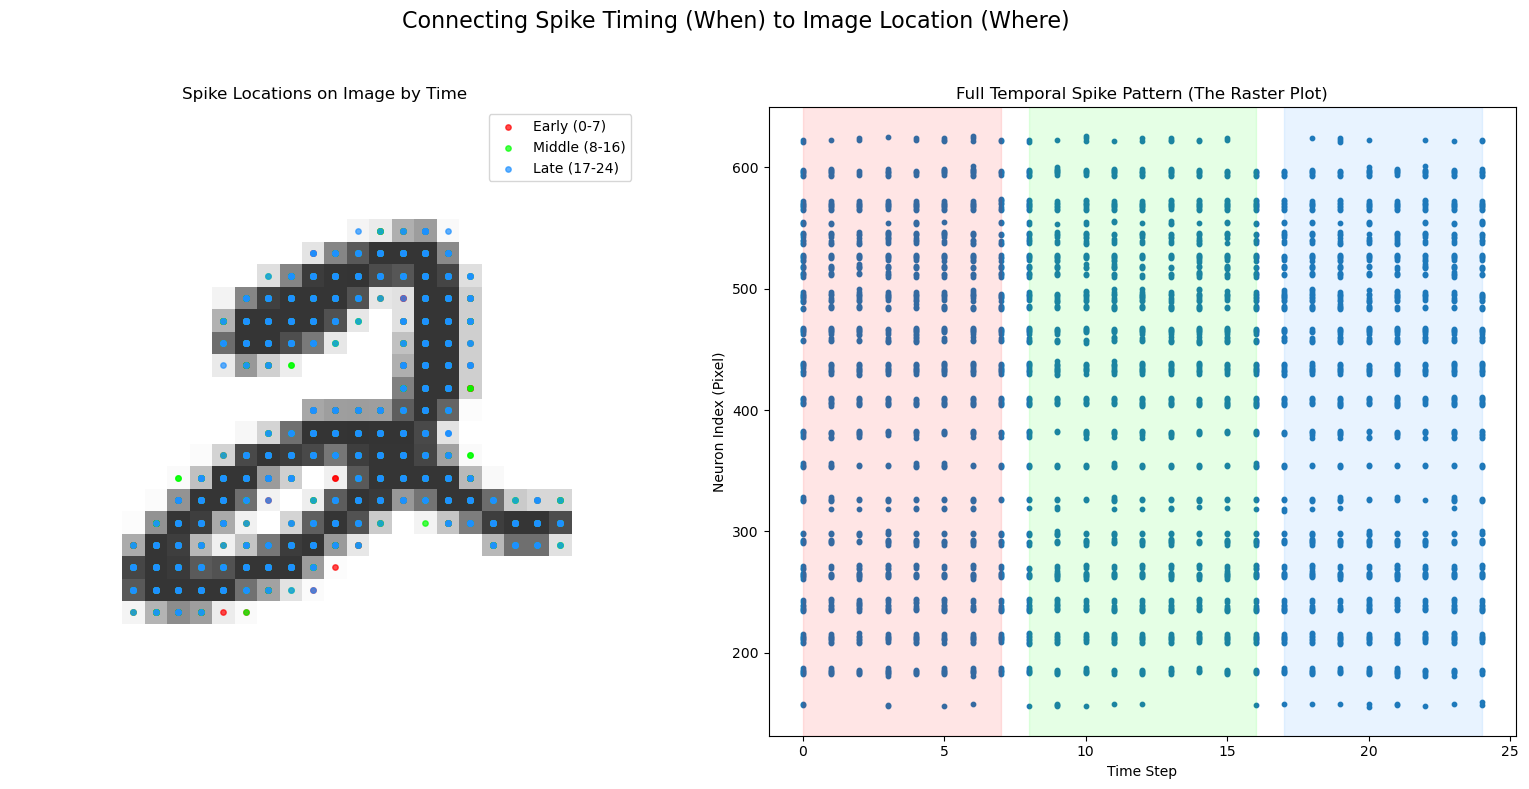

In [35]:
import torch
import snntorch as snn
from snntorch import spikegen, spikeplot as splt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# --- 1. Load the data and find our '2' ---
data_path = '/home/sebas_dev_linux/projects/snn_project/data/'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)

image_of_2 = None
for img, label in mnist_dataset:
    if label == 2:
        image_of_2 = img
        print("Found an image of a '2'.")
        break
if image_of_2 is None: raise ValueError("Could not find a '2' in the dataset.")

# --- 2. Generate the full spike train ---
num_steps = 25
flattened_image = image_of_2.view(1, -1)
full_spike_data = spikegen.rate(flattened_image, num_steps=num_steps).squeeze(1)

# --- 3. Define time intervals and find spike coordinates for each ---
# Define the time intervals for color coding
early_interval = (0, 8)
middle_interval = (8, 17)
late_interval = (17, 25)

# Lists to hold the (x, y) coordinates of spikes in each interval
early_spikes_coords = []
middle_spikes_coords = []
late_spikes_coords = []

# Loop through every time step and every neuron
num_neurons = full_spike_data.shape[1] # Should be 784
for t in range(num_steps):
    for n in range(num_neurons):
        if full_spike_data[t, n] == 1: # If a spike occurred
            # Convert neuron index 'n' back to 2D image coordinates (x, y)
            x_coord = n % 28  # Column
            y_coord = n // 28 # Row
            
            # Append the coordinate to the correct list based on time 't'
            if early_interval[0] <= t < early_interval[1]:
                early_spikes_coords.append((x_coord, y_coord))
            elif middle_interval[0] <= t < middle_interval[1]:
                middle_spikes_coords.append((x_coord, y_coord))
            else:
                late_spikes_coords.append((x_coord, y_coord))

print(f"Found {len(early_spikes_coords)} early spikes, {len(middle_spikes_coords)} middle spikes, and {len(late_spikes_coords)} late spikes.")

# --- 4. Create the final side-by-side visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Connecting Spike Timing (When) to Image Location (Where)", fontsize=16)

# --- Left Plot: Image with Colored Spike Overlays ---
ax = axes[0]
ax.imshow(image_of_2.squeeze(), cmap='gray_r', alpha=0.8) # Use reversed gray for better contrast
ax.set_title("Spike Locations on Image by Time")

# Unzip coordinates and plot each interval with scatter
if early_spikes_coords:
    x, y = zip(*early_spikes_coords)
    ax.scatter(x, y, c='red', s=15, label=f'Early ({early_interval[0]}-{early_interval[1]-1})', alpha=0.7)
if middle_spikes_coords:
    x, y = zip(*middle_spikes_coords)
    ax.scatter(x, y, c='lime', s=15, label=f'Middle ({middle_interval[0]}-{middle_interval[1]-1})', alpha=0.7)
if late_spikes_coords:
    x, y = zip(*late_spikes_coords)
    ax.scatter(x, y, c='dodgerblue', s=15, label=f'Late ({late_interval[0]}-{late_interval[1]-1})', alpha=0.7)

ax.legend(loc='upper right')
ax.set_axis_off()


# --- Right Plot: The Full Raster Plot ---
ax = axes[1]
splt.raster(full_spike_data, ax, s=10)
ax.set_title("Full Temporal Spike Pattern (The Raster Plot)")
ax.set_xlabel("Time Step")
ax.set_ylabel("Neuron Index (Pixel)")
ax.axvspan(early_interval[0], early_interval[1]-1, color='red', alpha=0.1)
ax.axvspan(middle_interval[0], middle_interval[1]-1, color='lime', alpha=0.1)
ax.axvspan(late_interval[0], late_interval[1]-1, color='dodgerblue', alpha=0.1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Defining the SNN Architecture

- We will create a simple feedforward network with one hidden layer. The structure is:
- Input Layer: 784 neurons (28x28 pixels)
- Hidden Layer: 1000 LIF neurons
- Output Layer: 10 LIF neurons (one for each digit 0-9)

Key Idea: The forward pass explicitly loops over time. At each step, it processes one slice of the spike data, updates the neuron states (mem1, mem2), and generates new spikes (spk1, spk2).

- num_inputs = 28*28: This defines the "front door" of our network. Since our input images are 28x28 pixels, we will have 784 input neurons, one for each pixel.
- num_hidden = 1000: This defines the size of our single hidden layer. A hidden layer is an intermediate layer of neurons that learns to recognize more complex patterns and features from the raw input. We've chosen to have 1000 neurons here. This number is a hyperparameter you can tune—more neurons can learn more complex patterns but are computationally more expensive.
- num_outputs = 10: This is the final layer. We have 10 output neurons because there are 10 possible classes of digits (0, 1, 2, ..., 9). Our goal is that for an image of a '7', the 7th neuron in this layer will be the most active.
- beta = 0.95: This is a crucial parameter for our spiking neurons. It controls the "leakiness" of the neuron's membrane potential.
Think of the neuron's potential as a bucket with a hole. beta is how much water is retained at each time step.
A beta of 0.95 means that at every single time step, the neuron's membrane potential decays by 5% (1.0 - 0.95).
A beta closer to 1.0 means the neuron has a "long memory" (leaks very slowly). A beta closer to 0.0 means it has a "short memory" (leaks very quickly).

class Net(nn.Module):: We define our network as a class that inherits from PyTorch's nn.Module. This is mandatory and gives our class a huge amount of built-in functionality, like tracking all its parameters.
super().__init__(): A required line that calls the constructor of the parent nn.Module class.
self.fc1 = nn.Linear(num_inputs, num_hidden): This creates our first "fully connected" (or linear) layer. This is a standard, non-spiking layer. Its job is to perform a matrix multiplication. It takes 784 inputs and calculates 1000 output values (we call these "currents"). It contains the learnable weights and biases.
self.lif1 = snn.Leaky(beta=beta): This creates our first spiking layer. This layer takes the 1000 "currents" from fc1 as input and applies the Leaky Integrate-and-Fire (LIF) dynamics. It is this layer that maintains the membrane potential, leaks, and generates the actual spikes.
self.fc2 = nn.Linear(num_hidden, num_outputs): Our second linear layer. It takes the 1000 outputs (spikes) from the hidden layer and calculates 10 final output values (currents for the last layer).
self.lif2 = snn.Leaky(beta=beta): Our final spiking layer. It takes the 10 currents from fc2 and generates the final output spikes for each of the 10-digit classes.

mem1 = self.lif1.init_leaky(): Before the movie starts, we reset the state of all neurons. This line initializes the membrane potential for all 1000 neurons in our hidden layer (lif1) to zero. We do the same for lif2. This ensures that the network's state from a previous data sample doesn't influence the current one.
spk2_rec = []: We create an empty list. We will use this to save the output spikes from the final layer at every single frame of the movie.
for step in range(num_steps):: This is the crucial loop. We are now going to iterate through our input x one time step at a time.
cur1 = self.fc1(x[step]): We take the current frame of the movie (x[step]) and pass it through the first linear layer. cur1 is the resulting "current."
spk1, mem1 = self.lif1(cur1, mem1): This is the key spiking step. We pass the current (cur1) and the previous membrane state (mem1) to our LIF neuron layer. It returns two things: spk1 (the output spikes it generated at this step) and the newly updated mem1 (which has integrated cur1 and also leaked a bit). This new mem1 will be passed back into this same line in the next loop iteration.
This process repeats for the second layer: The spikes from the first layer (spk1) are used as the input to the second linear layer (fc2) to generate a new current (cur2), which is then used by the second LIF layer (lif2) to generate the final output spikes (spk2).
spk2_rec.append(spk2): We take the final output spikes from this time step (spk2) and append them to our recording list.
return torch.stack(...): After the for loop has finished all 25 time steps, our spk2_rec list contains 25 tensors. This line stacks them all together into a single tensor, recreating a time dimension. The final returned tensor will have the shape [25, batch_size, 10], representing the full output spike movie.

In [40]:
# Network architecture parameters
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Neuron parameters (beta is the leak/decay rate)
beta = 0.95

# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta) # Leaky neuron
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta) # Leaky neuron

    def forward(self, x):
        # Initialize hidden states at the beginning of a sequence
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer's output spikes at each time step
        spk2_rec = []
        
        # The input 'x' is already encoded into spikes, with shape [time, batch, features]
        # We loop through time
        for step in range(num_steps):
            # Pass input spikes through the first layer
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            
            # Pass hidden layer spikes through the output layer
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # Store the output spikes
            spk2_rec.append(spk2)

        # Stack the recorded spikes along the time dimension
        return torch.stack(spk2_rec, dim=0)

# Instantiate the network and move it to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Setting up the Training Loop

Training an SNN is similar to a regular ANN, but with a twist. The spike generation function is non-differentiable. snnTorch handles this automatically using surrogate gradients, so we can use standard PyTorch optimizers.
The loss will be calculated based on the total spike count from each output neuron. The neuron that spikes the most for a given input image is our predicted class.

The Loss Function: The "Critic"
loss = nn.CrossEntropyLoss()
What it is: This is our "error calculator" or "critic." Its job is to compare the network's prediction with the correct answer and output a single number—the loss—that quantifies how wrong the network was. A high loss means a very wrong prediction; a loss near zero means a very good one.
How it works for SNNs (The Crucial Part): CrossEntropyLoss is designed for classification. It expects two things:
The network's raw, unnormalized scores for each class (often called "logits").
The correct class label (e.g., the number 5).
In our SNN, the "raw score" is the total number of spikes each output neuron fires. If the 3rd output neuron fires 15 times and the 7th neuron fires 4 times, their scores are 15 and 4. The loss function will learn that for an image of a '3', the score for the 3rd neuron should be much higher than all others.
The Optimizer: The "Tuner"
optimizer = torch.optim.Adam(...)
What it is: If the loss function is the critic, the optimizer is the "mechanic" or "tuner." It's the algorithm that actually adjusts the network's internal parameters (the weights in fc1 and fc2) to try and reduce the loss.
How it works:
net.parameters(): This tells the optimizer which knobs it's allowed to tune—all the learnable weights and biases inside our net model.
lr=5e-4: This is the learning rate. It's the most important hyperparameter. It controls how big of an adjustment the optimizer makes after each mistake. A tiny lr means slow learning; a huge lr can cause the network to become unstable. 5e-4 (or 0.0005) is a common, safe starting point.
betas=(0.9, 0.999): These are parameters specific to the Adam optimizer that control its "momentum." You can think of them as helping the optimizer to move more consistently in the right direction. The default values are almost always a good choice.


for epoch in range(num_epochs):: An epoch is one complete pass through the entire training dataset (all 60,000 images). We're only doing one epoch here for a quick demonstration.
for i, (data, targets) in enumerate(train_loader):: This is the inner loop. It iterates through our train_loader, grabbing one batch of data at a time. In our case, data will be a tensor of 128 images, and targets will be a tensor of their 128 correct labels.


spike_count = torch.sum(spk_rec, dim=0): This is the crucial SNN step. We collapse the time dimension. We sum up all the spikes that each of the 10 output neurons fired over the 25 time steps. This transforms our [25, 128, 10] tensor into a [128, 10] tensor, which represents the final "score" for each of the 128 images in the batch.
loss_val = loss(spike_count, targets): We hand the scores (spike_count) and the correct answers (targets) to our "critic" (loss). It calculates a single number, loss_val, representing how badly the network performed on this batch.

This is the three-step "learning recipe" in PyTorch.
optimizer.zero_grad(): We erase any old calculations from the previous batch.
loss_val.backward(): This is the most magical step. PyTorch's autograd engine works backwards from the final loss_val through all the calculations in the network to figure out how much each individual weight contributed to the error. This is called backpropagation. For an SNN, snnTorch cleverly uses surrogate gradients here to solve the problem of non-differentiable spikes, allowing this step to work.
optimizer.step(): The "tuner" (optimizer) now uses the information from .backward() to adjust all of the network's weights (net.parameters()) slightly in the direction that will make the loss smaller on the next try.



In [59]:
# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # 1. Encode data into spikes
        spike_data = spikegen.rate(data.view(data.size(0), -1), num_steps=num_steps)
        
        # 2. Forward pass
        net.train()
        spk_rec = net(spike_data)
        
        # 3. Calculate loss
        # The output spk_rec is [time, batch, output_neurons]
        # We sum the spikes over time to get the total spike count for each neuron
        spike_count = torch.sum(spk_rec, dim=0) # shape: [batch, output_neurons]
        loss_val = loss(spike_count, targets)

        # 4. Gradient descent
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Iteration {i}/{len(train_loader)}")
            print(f"Loss: {loss_val.item():.4f}")

            # Check accuracy on a small batch
            with torch.no_grad():
                net.eval()
                _, predicted = torch.max(spike_count.data, 1)
                total = targets.size(0)
                correct = (predicted == targets).sum().item()
                print(f"Training Accuracy: {(100 * correct / total):.2f}%\n")

print("Training Complete!")

Epoch 1/2, Iteration 0/469
Loss: 0.0423
Training Accuracy: 99.22%

Epoch 1/2, Iteration 100/469
Loss: 0.0055
Training Accuracy: 100.00%

Epoch 1/2, Iteration 200/469
Loss: 0.0519
Training Accuracy: 97.66%

Epoch 1/2, Iteration 300/469
Loss: 0.0094
Training Accuracy: 100.00%

Epoch 1/2, Iteration 400/469
Loss: 0.0464
Training Accuracy: 98.44%

Epoch 2/2, Iteration 0/469
Loss: 0.0186
Training Accuracy: 99.22%

Epoch 2/2, Iteration 100/469
Loss: 0.0282
Training Accuracy: 99.22%

Epoch 2/2, Iteration 200/469
Loss: 0.0086
Training Accuracy: 99.22%

Epoch 2/2, Iteration 300/469
Loss: 0.0463
Training Accuracy: 98.44%

Epoch 2/2, Iteration 400/469
Loss: 0.0276
Training Accuracy: 99.22%

Training Complete!


# Creating the Test Loop

- Now we'll evaluate the trained network on the test set. The logic is the same, but we don't perform backpropagation.
- After just one epoch, you should already see an accuracy of >90%, which is fantastic! Training for more epochs will improve it further.

In [43]:
def test_accuracy(data_loader, net, num_steps):
    total = 0
    correct = 0
    
    with torch.no_grad():
        net.eval()
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # Encode and forward pass
            spike_data = spikegen.rate(data.view(data.size(0), -1), num_steps=num_steps)
            spk_rec = net(spike_data)
            
            # Get prediction from spike count
            spike_count = torch.sum(spk_rec, dim=0)
            _, predicted = torch.max(spike_count.data, 1)
            
            # Update totals
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

# Run the test
test_acc = test_accuracy(test_loader, net, num_steps)
print(f"Test set accuracy: {test_acc:.2f}%")

Test set accuracy: 97.63%


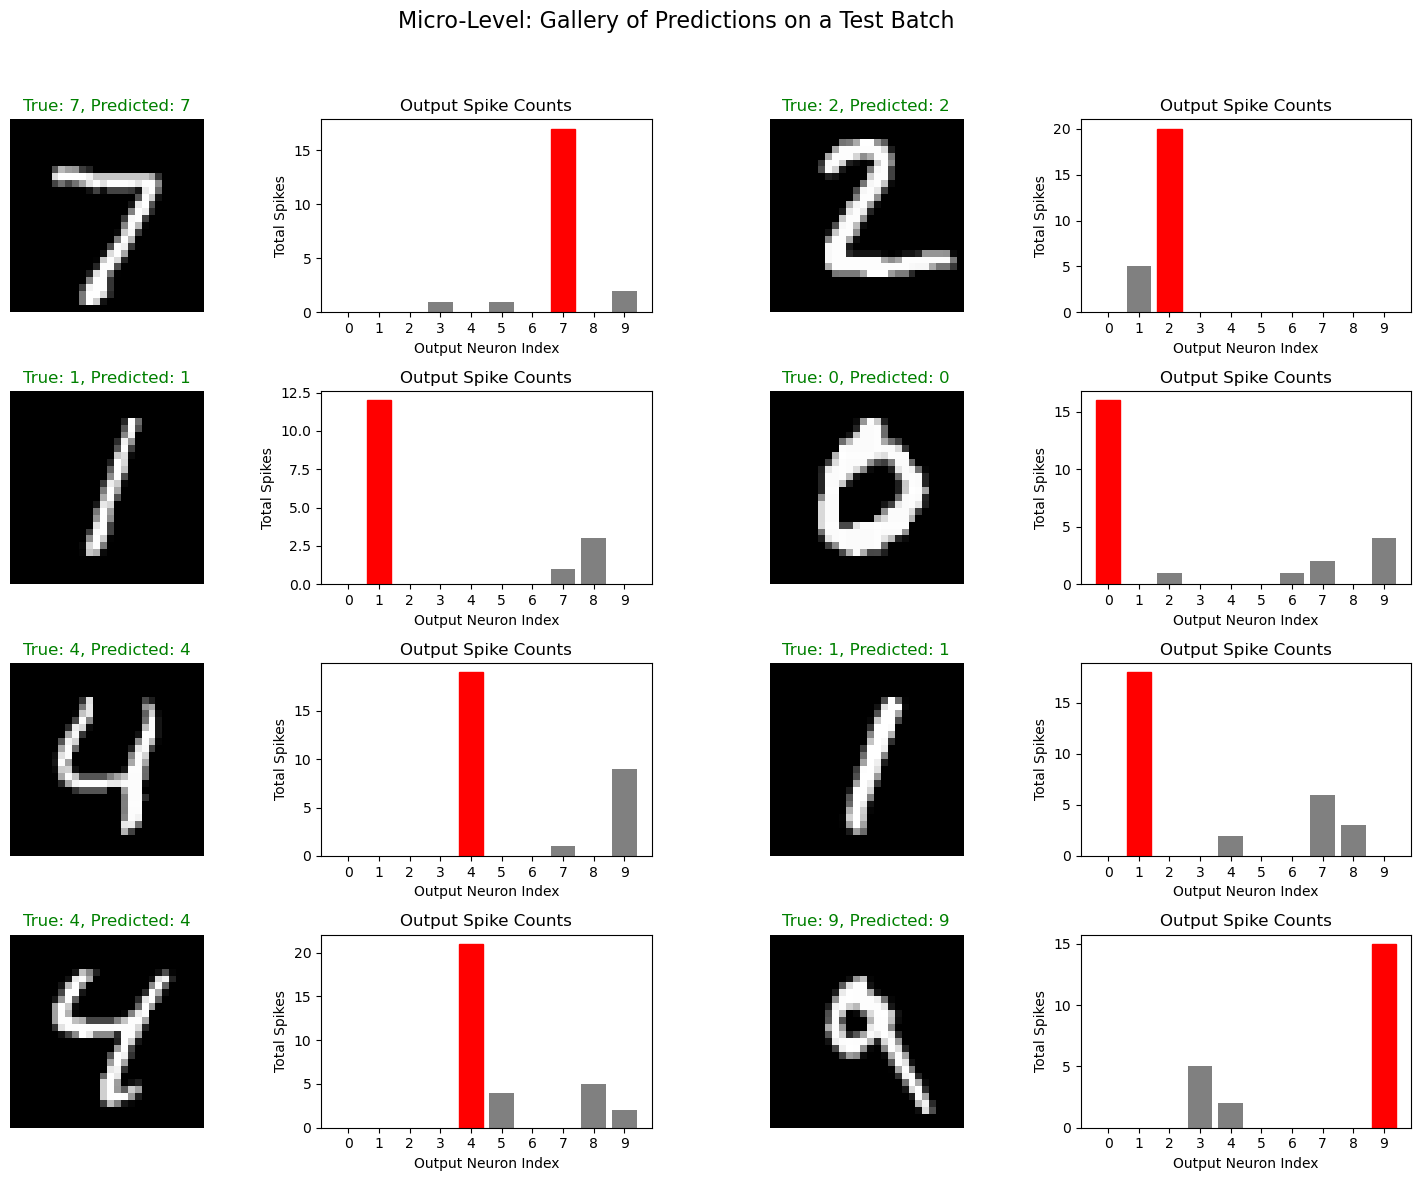

In [60]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen, spikeplot as splt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# --- Recreate the Network and Load Data (from previous steps) ---
# Ensure you have the trained `net` model from the previous step.
# If not, you'd need to re-run the network definition and training code.

# Let's assume `net` is your trained network model.
# Let's also assume `test_loader` and `device` are defined.
# num_steps = 25

# --- Start of the Visualization Code ---

# Get one batch from the test set
data_iterator = iter(test_loader)
images, labels = next(data_iterator)
images = images.to(device)
labels = labels.to(device)

# --- Run this single batch through the network ---
with torch.no_grad():
    net.eval()
    # Encode and forward pass
    spike_data = spikegen.rate(images.view(images.size(0), -1), num_steps=num_steps)
    spk_rec = net(spike_data)
    
    # Get spike counts and predictions
    spike_counts = torch.sum(spk_rec, dim=0)
    _, predicted = torch.max(spike_counts.data, 1)

# --- Create the Gallery ---
# Let's visualize the first 8 images from this batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.suptitle("Micro-Level: Gallery of Predictions on a Test Batch", fontsize=16)

for i in range(4):
    for j in range(2):
        idx = i * 2 + j # Index for the image in the batch
        
        # --- Plot 1: The Image ---
        img_ax = axes[i, j*2]
        img_ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
        img_ax.set_axis_off()
        is_correct = (predicted[idx] == labels[idx]).item()
        title_color = 'green' if is_correct else 'red'
        img_ax.set_title(f"True: {labels[idx].item()}, Predicted: {predicted[idx].item()}", color=title_color)
        
        # --- Plot 2: The Spike Count Bar Chart ---
        bar_ax = axes[i, j*2 + 1]
        neuron_indices = np.arange(10)
        counts = spike_counts[idx].cpu().numpy()
        
        bars = bar_ax.bar(neuron_indices, counts, color='gray')
        # Highlight the true and predicted bars
        bars[labels[idx]].set_color('blue')
        bars[predicted[idx]].set_color('red')
        
        bar_ax.set_xticks(neuron_indices)
        bar_ax.set_title("Output Spike Counts")
        bar_ax.set_xlabel("Output Neuron Index")
        bar_ax.set_ylabel("Total Spikes")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Step 7: Visualizing the Results

--- Analyzing a randomly selected sample (index 70 from the batch) ---


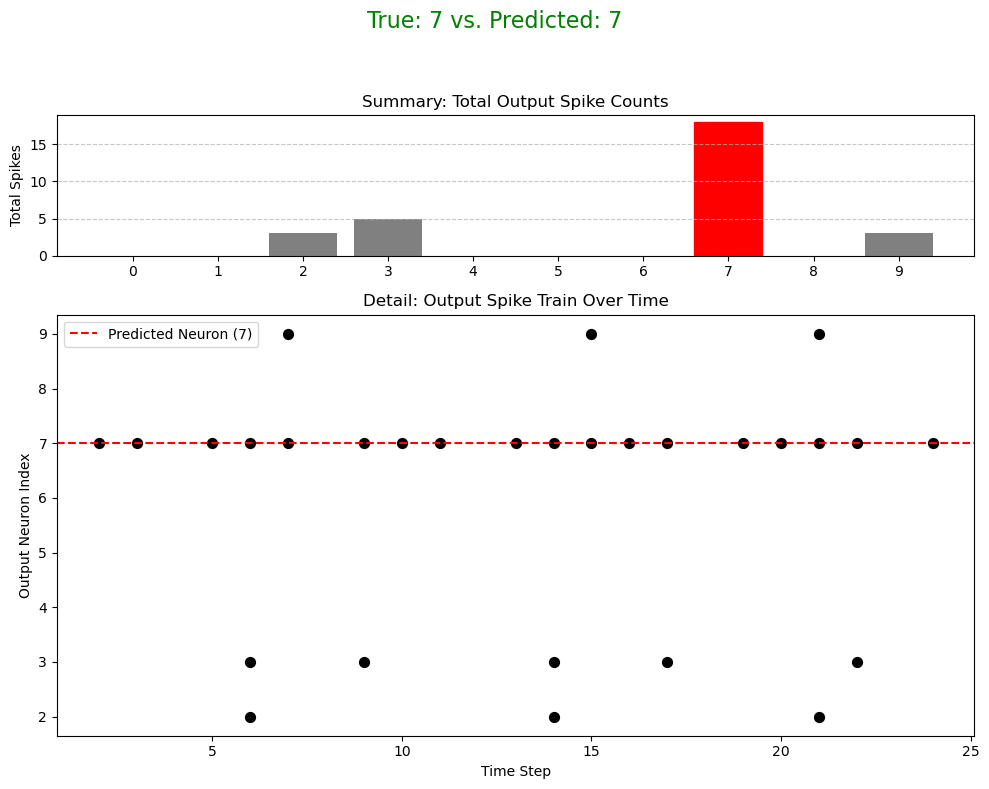

In [50]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen, spikeplot as splt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random # Import the random library

# --- Recreate Network, Load Data, and define test_loader, device, num_steps ---
# (Assume this is all done from previous steps and you have a trained `net`)

# --- Start of the Visualization ---

# 1. Grab a single BATCH of test data
data_iterator = iter(test_loader)
images, labels = next(data_iterator)
images = images.to(device)
labels = labels.to(device)

# 2. Run the ENTIRE batch through the network (this is efficient)
with torch.no_grad():
    net.eval()
    spike_data = spikegen.rate(images.view(images.size(0), -1), num_steps=num_steps)
    spk_rec = net(spike_data) # Output shape: [time, batch, neurons] -> [25, 128, 10]
    
    spike_counts = torch.sum(spk_rec, dim=0) # Shape: [128, 10]
    _, predicted = torch.max(spike_counts.data, 1) # Shape: [128]

# 3. Pick a RANDOM index from this batch
batch_size = images.size(0)
random_idx = random.randint(0, batch_size - 1)
print(f"--- Analyzing a randomly selected sample (index {random_idx} from the batch) ---")


# 4. Extract the data for ONLY our random sample
sample_image = images[random_idx]
sample_label = labels[random_idx]
sample_prediction = predicted[random_idx]
sample_spike_counts = spike_counts[random_idx]
# Select the spike records for our random sample from the batch dimension
sample_spk_rec = spk_rec[:, random_idx, :] # Shape: [25, 10]


# --- 5. Create the combined visualization ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 3]})
is_correct = (sample_prediction == sample_label).item()
title_color = 'green' if is_correct else 'red'
fig.suptitle(f"True: {sample_label.item()} vs. Predicted: {sample_prediction.item()}", fontsize=16, color=title_color)


# --- Top Plot: The Summary (Spike Count Bar Chart) ---
ax = axes[0]
neuron_indices = np.arange(10)
counts = sample_spike_counts.cpu().numpy()
bars = ax.bar(neuron_indices, counts, color='gray')

bars[sample_label.cpu()].set_color('blue')
bars[sample_prediction.cpu()].set_color('red')

ax.set_title("Summary: Total Output Spike Counts")
ax.set_ylabel("Total Spikes")
ax.set_xticks(neuron_indices)
ax.grid(axis='y', linestyle='--', alpha=0.7)


# --- Bottom Plot: The Detail (Output Spike Raster Plot) ---
ax = axes[1]
splt.raster(sample_spk_rec, ax, s=50, c='black') # Plot the [25, 10] tensor
ax.set_title("Detail: Output Spike Train Over Time")
ax.set_xlabel("Time Step")
ax.set_ylabel("Output Neuron Index")

# Highlight the winning neuron's row
ax.axhline(y=sample_prediction.cpu(), color='red', linestyle='--', label=f'Predicted Neuron ({sample_prediction.item()})')
ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In the output raster plot, you should see a horizontal band of spikes corresponding to the correct digit's neuron index. For example, if the input image is a "7", you should see neuron #7 firing much more frequently than the others.